In [3]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import Planetoid
import os
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.utils import degree, to_networkx
from collections import Counter
from torch_geometric.utils import degree



np.random.seed(0)

     |████████████████████████████████| 9.4 MB 44.1 MB/s 
     |████████████████████████████████| 4.5 MB 23.0 MB/s 
     |████████████████████████████████| 512 kB 35.6 MB/s 
     |████████████████████████████████| 280 kB 73.2 MB/s 


In [1]:
!pip install scipy==1.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.6 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [4]:
dataset = 'CiteSeer'
path = os.path.join(os.getcwd(), 'data', 'Planetoid')
dataset = Planetoid(path, dataset)
data = dataset[0]

Processing...
Done!


In [5]:
def calc_acc(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [6]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_hidden, dim_out):
    super().__init__()
    self.l1 = GCNConv(dim_in, dim_hidden)
    self.l2 = GCNConv(dim_hidden, dim_out)

  def forward(self, x, e_idx, p=0.5):
    x = F.dropout(x, p, training=self.training)
    x = torch.relu(self.l1(x, e_idx))
    x = F.dropout(x, p, training=self.training)
    x = self.l2(x, e_idx)
    return x, F.log_softmax(x, dim=1)

In [7]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_hidden, dim_out, hidden_heads=8):
    super().__init__()
    mult_hidden = dim_hidden * hidden_heads
    self.l1 = GATv2Conv(dim_in, dim_hidden, heads=hidden_heads)
    self.l2 = GATv2Conv(mult_hidden, dim_out, heads=1)

  def forward(self, x, e_idx, p=0.5):
    x = F.dropout(x, p, training=self.training)
    x = F.elu(self.l1(x, e_idx))
    x = F.dropout(x, p, training=self.training)
    x = self.l2(x, e_idx)
    return x, F.log_softmax(x, dim=1)

In [8]:
cross_entropy = torch.nn.CrossEntropyLoss()

def train(model, data, optimizer, epoch_nr=190):
    def calc_loss(pred_y, true_y):
      return cross_entropy(pred_y, true_y)

    model.train()
    for e in range(epoch_nr):
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        pred_y = out[data.train_mask]
        true_y = data.y[data.train_mask]
        loss = calc_loss(pred_y, true_y)
        acc = calc_acc(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(e % 10 == 0):
          print("Epoch: " + str(e) + "  Train acc: " + str(acc*100) + "%")


def test(model, data):
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = calc_acc(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [9]:
# GCN

gcn = GCN(dataset.num_features, 16, dataset.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.03, weight_decay=5e-4)
train(gcn, data, optimizer_gcn)
acc = test(gcn, data)
print('test accuracy ' + str(acc*100) + "%")

Epoch: 0  Train acc: 21.666666865348816%
Epoch: 10  Train acc: 94.9999988079071%
Epoch: 20  Train acc: 99.16666746139526%
Epoch: 30  Train acc: 98.33333492279053%
Epoch: 40  Train acc: 99.16666746139526%
Epoch: 50  Train acc: 97.50000238418579%
Epoch: 60  Train acc: 98.33333492279053%
Epoch: 70  Train acc: 96.66666388511658%
Epoch: 80  Train acc: 98.33333492279053%
Epoch: 90  Train acc: 96.66666388511658%
Epoch: 100  Train acc: 95.83333134651184%
Epoch: 110  Train acc: 98.33333492279053%
Epoch: 120  Train acc: 96.66666388511658%
Epoch: 130  Train acc: 100.0%
Epoch: 140  Train acc: 98.33333492279053%
Epoch: 150  Train acc: 98.33333492279053%
Epoch: 160  Train acc: 98.33333492279053%
Epoch: 170  Train acc: 97.50000238418579%
Epoch: 180  Train acc: 98.33333492279053%
test accuracy 64.0999972820282%


In [10]:
# GAT
gat = GAT(dataset.num_features, 8, dataset.num_classes)
optimizer_gat = torch.optim.Adam(gat.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-3)
train(gat, data, optimizer_gat)
acc = test(gat, data)
print('test accuracy ' + str(acc*100) + "%")

Epoch: 0  Train acc: 15.833333134651184%
Epoch: 10  Train acc: 95.83333134651184%
Epoch: 20  Train acc: 99.16666746139526%
Epoch: 30  Train acc: 99.16666746139526%
Epoch: 40  Train acc: 100.0%
Epoch: 50  Train acc: 99.16666746139526%
Epoch: 60  Train acc: 99.16666746139526%
Epoch: 70  Train acc: 100.0%
Epoch: 80  Train acc: 100.0%
Epoch: 90  Train acc: 100.0%
Epoch: 100  Train acc: 100.0%
Epoch: 110  Train acc: 99.16666746139526%
Epoch: 120  Train acc: 100.0%
Epoch: 130  Train acc: 100.0%
Epoch: 140  Train acc: 100.0%
Epoch: 150  Train acc: 100.0%
Epoch: 160  Train acc: 100.0%
Epoch: 170  Train acc: 100.0%
Epoch: 180  Train acc: 100.0%
test accuracy 68.30000281333923%


In [11]:
degree_str = ['0','1','2','3','4','5','6', '7', 'more than 7']

In [12]:
def plot_degrees(model, color):
  acc_array = []
  mask_len = []
  _, ans = model(data.x, data.edge_index)

  for i in range(0, 8):
    selected = np.where(degree(data.edge_index[0]).numpy() == i)
    mask_len.append(len(selected[0]))
    pred_y = ans.argmax(dim=1)[selected[0]]
    true_y = data.y[selected[0]]
    acc = calc_acc(pred_y, true_y)
    acc_array.append(acc)
    
  selected = np.where(degree(data.edge_index[0]).numpy() > 7)
  mask_len.append(len(selected[0]))
  pred_y = ans.argmax(dim=1)[selected[0]]
  true_y = data.y[selected[0]]
  acc_array.append(calc_acc(pred_y, true_y))
  
  fig, ax = plt.subplots(figsize=(13, 8))

  ax.set_ylabel('accuracy in %')
  ax.set_xlabel('node degree')
  plt.bar(degree_str,
          acc_array,
          color=color)

  for i in range(0, 9):
    print("degree: " + degree_str[i] + "  accuracy: " + str(acc_array[i]*100) + "%")
    plt.text(i, acc_array[i] // 2, mask_len[i], va='bottom', ha='center',
               color='black', size=20)

degree: 0  accuracy: 50.0%
degree: 1  accuracy: 56.498873233795166%
degree: 2  accuracy: 67.92452931404114%
degree: 3  accuracy: 67.80821681022644%
degree: 4  accuracy: 73.41772317886353%
degree: 5  accuracy: 76.25899314880371%
degree: 6  accuracy: 75.45454502105713%
degree: 7  accuracy: 72.13114500045776%
degree: more than 7  accuracy: 79.76190447807312%


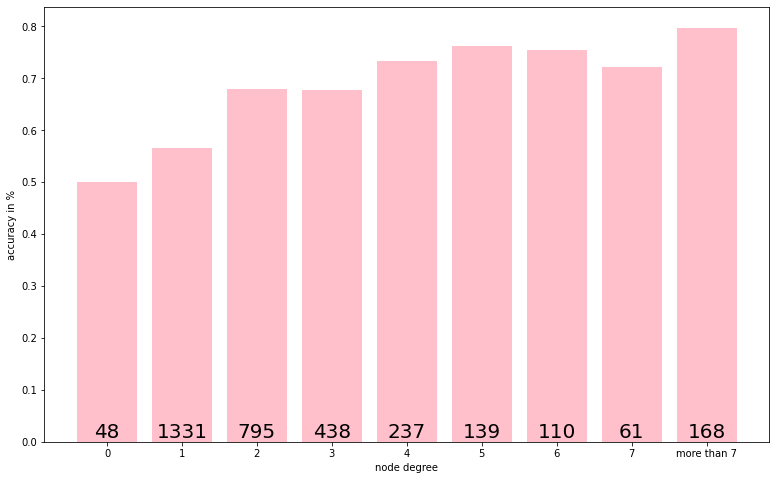

In [13]:
plot_degrees(gcn, 'pink')

degree: 0  accuracy: 52.08333134651184%
degree: 1  accuracy: 60.03005504608154%
degree: 2  accuracy: 69.55974698066711%
degree: 3  accuracy: 72.60273694992065%
degree: 4  accuracy: 75.10548233985901%
degree: 5  accuracy: 79.8561155796051%
degree: 6  accuracy: 79.09091114997864%
degree: 7  accuracy: 78.68852615356445%
degree: more than 7  accuracy: 84.52380895614624%


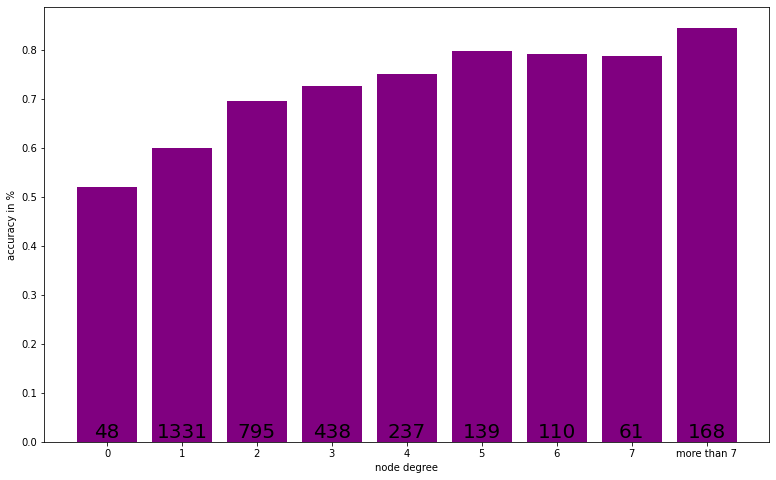

In [14]:
plot_degrees(gat, 'purple')